In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import torchvision.models as models

In [4]:
img_dir = './dataset/Flickr8k_Dataset/'
ann_dir = './dataset/Flickr8k_text/Flickr8k.token.txt'
train_dir = './dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
val_dir = './dataset/Flickr8k_text/Flickr_8k.devImages.txt'
test_dir = './dataset/Flickr8k_text/Flickr_8k.testImages.txt'

In [5]:
class Flickr8kDataset(Dataset):
    """Flickr8k dataset."""
    
    def __init__(self, img_dir, split_dir, ann_dir, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            ann_dir (string): Directory with all the tokens
            split_dir (string): Directory with all the file names which belong to a certain split(train/dev/test)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.split_dir = split_dir
        self.images, self.captions, self.tokenized_captions, self.V, self.SOS, self.EOS = self.tokenizer(self.split_dir, self.ann_dir)
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
#                 transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
    
    def tokenizer(self, split_dir, ann_dir):
        images = []
        captions = []
        tokenized_captions = []
        
        with open(split_dir, "r") as split_f:
            sub_lines = split_f.readlines()
        
        with open(ann_dir, "r") as ann_f:
            for line in ann_f:
                if line.split("#")[0] + "\n" in sub_lines:
                    images.append(line.split()[0])
                    captions.append(line.split()[1:])


        vocab = []
        for caption in captions:
            for word in caption:
                if word not in vocab:
                    vocab.append(word)

        V = len(vocab)
        SOS = 0
        EOS = V + 1

        word_2_token = dict(zip(vocab, list(range(1, V + 1))))

        for caption in captions:
            temp = []
            for word in caption:
                temp.append(word_2_token[word])
            temp.insert(0, SOS)
            temp.append(EOS)
            tokenized_captions.append(temp)
            
        assert(len(images) == len(captions))
            
        return images, captions, tokenized_captions, V, SOS, EOS
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name, cap_tok, caption = self.images[idx], self.tokenized_captions[idx], self.captions[idx]
        img_name, instance = img_name.split('#')
        img_name = os.path.join(self.img_dir,
                                img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        cap_tok = torch.tensor(cap_tok)
        sample = {'image': image, 'cap_tok': cap_tok, 'caption': caption}

        

        return sample

In [6]:
train_data = Flickr8kDataset(img_dir, train_dir, ann_dir)
val_data = Flickr8kDataset(img_dir, val_dir, ann_dir)
test_data = Flickr8kDataset(img_dir, test_dir, ann_dir)

In [7]:
def display_sample(sample):
    image = sample['image']
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    image = inv_normalize(image)
    caption = ' '.join(sample['caption'])
    cap_tok = sample['cap_tok']
    plt.figure()
    plt.imshow(image.permute(1,2,0))
    print("Caption: ", caption)
    print("Tokenized Caption: ", cap_tok)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption:  A child in a pink dress is climbing up a set of stairs in an entry way .
Tokenized Caption:  tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,    4,   10,
          11,   12,    3,   13,   14,   15,   16, 8255])


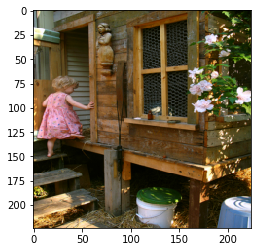

In [8]:
display_sample(train_data[0])

In [9]:
def collater(batch):
    '''This functions pads the cpations and makes them equal length
    '''
    
    cap_lens = torch.tensor([len(item['cap_tok']) for item in batch]) #Includes SOS and EOS as part of the length
    caption_list = [item['cap_tok'] for item in batch]
    padded_captions = pad_sequence(caption_list, padding_value=9631)
    images = torch.stack([item['image'] for item in batch])

    return images, padded_captions, cap_lens

In [10]:
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collater)

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.model = models.resnet18(pretrained=True)
        self.model = nn.Sequential(*(list(self.model.children())[:7]))
        self.model.requires_grad_(False)
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x,2,3)
        x = x.permute(2,0,1)
        return x

encoder = Encoder()

In [14]:
for data in train_dataloader:
    images, captions, cap_lens = data
    res = encoder(images)
    print(res.shape)
    input()

torch.Size([196, 4, 256])


KeyboardInterrupt: 

In [ ]:
class Decoder(torch.nn.Module):
    '''Decode source sequence embeddings into distributions over targets

    See :func:`__init__` and :func:`init_submodules` for a description of the
    attributes.

    Attributes
    ----------
    target_vocab_size : int
    pad_id : int
    word_embedding_size : int
    hidden_state_size : int
    cell_type : {'rnn', 'lstm', 'gru'}
    embedding : torch.nn.Embedding
    cell : {torch.nn.GRUCell, torch.nn.LSTMCell, torch.nn.RNNCell}
    ff : torch.nn.Linear
    '''

    def __init__(
            self, target_vocab_size, pad_id=-1, word_embedding_size=1024,
            hidden_state_size=1024, cell_type='lstm'):
        '''Initialize the decoder

        Sets some non-parameter attributes, then calls :func:`init_submodules`.

        Parameters
        ----------
        target_vocab_size : int
            The size of the target language vocabulary, including `pad_id`
        pad_id : int, optional
            The index within `output_vocab_size` which is used to right-pad
            shorter input to the length of the longest input in the batch.
            Negative values between ``-1`` and ``-vocab_size`` inclusive are
            converted to positive indices by ``pad_id' = vocab_size + pad_id``.
        word_embedding_size : int, optional
            The size of your static (target) word embedding vectors.
        hidden_state_size : int, optional
            The size of the output of a recurrent layer for one slice of time
            in one direction.
        cell_type : {'rnn', 'lstm', 'gru'}, optional
            What underlying recurrent architecture to use when building the
            `rnn` submodule. See :func:`init_submodules` for more info.
        '''
        super().__init__()
        self.target_vocab_size = target_vocab_size
        self.pad_id = pad_id
        self.word_embedding_size = word_embedding_size
        self.hidden_state_size = hidden_state_size
        self.cell_type = cell_type
        self.embedding = self.cell = self.ff = None
        self.init_submodules()

    def init_submodules(self):
        '''Initialize the parameterized submodules of this network

        This method sets the following object attributes (sets them in
        `self`):

        embedding : torch.nn.Embedding
            A layer that extracts learned token embeddings for each index in
            a token sequence. It must not learn an embedding for padded tokens.
        cell : {torch.nn.RNNCell, torch.nn.GRUCell, torch.nn.LSTMCell}
            A layer corresponding to the recurrent neural network that
            processes target word embeddings into hidden states. We only define
            one cell and one layer
        ff : torch.nn.Linear
            A fully-connected layer that converts the decoder hidden state
            into an un-normalized log probability distribution over target
            words
        '''
        self.embedding = torch.nn.Embedding(self.target_vocab_size, self.word_embedding_size, self.pad_id)
        if self.cell_type == 'rnn':
            self.cell = torch.nn.RNNCell(input_size=self.word_embedding_size + self.hidden_state_size, hidden_size=self.hidden_state_size)
        elif self.cell_type == 'gru':
            self.cell = torch.nn.GRUCell(input_size=self.word_embedding_size + self.hidden_state_size, hidden_size=self.hidden_state_size)
        else:
            self.cell = torch.nn.LSTMCell(input_size=self.word_embedding_size + self.hidden_state_size, hidden_size=self.hidden_state_size)
        self.ff = torch.nn.Linear(self.hidden_state_size, self.target_vocab_size)

    def forward(self, E_tm1, htilde_tm1, h):
        if htilde_tm1 is None:
            htilde_tm1 = self.get_first_hidden_state(h)
            if self.cell_type == 'lstm':
                # initialize cell state with zeros
                htilde_tm1 = (htilde_tm1, torch.zeros_like(htilde_tm1))
        xtilde_t = self.get_current_rnn_input(E_tm1, htilde_tm1, h)
        h_t = self.get_current_hidden_state(xtilde_t, htilde_tm1)
        if self.cell_type == 'lstm':
            logits_t = self.get_current_logits(h_t[0])
        else:
            logits_t = self.get_current_logits(h_t)
        return logits_t, h_t

    def get_first_hidden_state(self, h):
        '''Get the initial decoder hidden state, prior to the first input

        Parameters
        ----------
        h : torch.FloatTensor
            A float tensor of shape ``(S, N, self.hidden_state_size)`` of
            hidden states of the encoder. ``h[s, n, i]`` is the
            ``i``-th index of the encoder RNN's last hidden state at time ``s``
            of the ``n``-th sequence in the batch. The states of the
            encoder have been right-padded such that

        Returns
        -------
        htilde_0 : torch.FloatTensor
            A float tensor of shape ``(N, self.hidden_state_size)``, where
            ``htilde_0[n, i]`` is the ``i``-th index of the decoder's first
            (pre-sequence) hidden state for the ``n``-th sequence in the back

        Notes
        -----
        You will or will not need `h` and `F_lens`, depending on
        whether this decoder uses attention.

        `h` is the output of a bidirectional layer. Assume
        ``h[..., :self.hidden_state_size // 2]`` correspond to the
        hidden states in the forward direction and
        ``h[..., self.hidden_state_size // 2:]`` to those in the
        backward direction.

        In the case of an LSTM, we will initialize the cell state with zeros
        later on (don't worry about it).
        '''
        htilde_tm1 = torch.zeros_like(h, device=h.device)
        return htilde_tm1[0]

    def get_current_rnn_input(self, E_tm1, htilde_tm1, h):
        '''Get the current input the decoder RNN

        Parameters
        ----------
        E_tm1 : torch.LongTensor
            An integer tensor of shape ``(N,)`` denoting the target language
            token ids output from the previous decoder step. ``E_tm1[n]`` is
            the token corresponding to the ``n``-th element in the batch. If
            ``E_tm1[n] == self.pad_id``, then the target sequence has ended
        h : torch.FloatTensor
            A float tensor of shape ``(S, N, self.hidden_state_size)`` of
            hidden states of the encoder. ``h[s, n, i]`` is the
            ``i``-th index of the encoder RNN's last hidden state at time ``s``
            of the ``n``-th sequence in the batch. The states of the
            encoder have been right-padded such that ``h[F_lens[n]:, n]``
            should all be ignored.
        F_lens : torch.LongTensor
            An integer tensor of shape ``(N,)`` corresponding to the lengths
            of the encoded source sentences.

        Returns
        -------
        xtilde_t : torch.FloatTensor
            A float tensor of shape ``(N, Itilde)`` denoting the current input
            to the decoder RNN. ``xtilde_t[n, :self.word_embedding_size]``
            should be a word embedding for ``E_tm1[n]``. If
            ``E_tm1[n] == self.pad_id``, then ``xtilde_t[n] == 0.``. If this
            decoder uses attention, ``xtilde_t[n, self.word_embedding_size:]``
            corresponds to the attention context vector.

        Notes
        -----
        You will or will not need `htilde_tm1`, `h` and `F_lens`, depending on
        whether this decoder uses attention.

        ``xtilde_t[n, self.word_embedding_size:]`` should not be masked out,
        regardless of whether ``E_tm1[n] == self.pad_id``
        '''
        xtilde_t = torch.cat((self.embedding(E_tm1),self.attend(htilde_tm1, h)),axis=1)
        return xtilde_t
    
    def attend(self, htilde_t, h):
        '''compute context vector c_t. Use get_attention_weights() to calculate
        alpha_t.
        htilde_t is of shape (N, 2 * H)
        h is of shape (S, N, 2 * H)
        F_lens is of shape (N,)
        c_t (output) is of shape (N, 2 * H)
        '''
        alphas = self.get_attention_weights(htilde_t, h).unsqueeze(-1)
        c_t = (h * alphas).sum(dim=0)
        return c_t


    def get_attention_weights(self, htilde_t, h):
        '''DO NOT MODIFY! Calculates attention weights, ensuring padded terms
        in h have weight 0 and no gradient. You have to implement
        get_energy_scores()
        alpha_t (output) is of shape (S, N)
        '''
        e_t = self.get_energy_scores(htilde_t, h)
#         pad_mask = torch.arange(h.shape[0], device=h.device)
#         pad_mask = pad_mask.unsqueeze(-1) >= F_lens  # (S, N)
#         e_t = e_t.masked_fill(pad_mask, -float('inf'))
        return torch.nn.functional.softmax(e_t, 0)

    def get_energy_scores(self, htilde_t, h):
        '''Determine energy scores via cosine similarity
        htilde_t is of shape (N, 2 * H)
        h is of shape (S, N, 2 * H)
        e_t (output) is of shape (S, N)
        '''
        if self.cell_type == 'lstm':
            return torch.nn.functional.cosine_similarity(htilde_t[0].unsqueeze(0), h, 2)
        return torch.nn.functional.cosine_similarity(htilde_t.unsqueeze(0), h, 2)

    def get_current_hidden_state(self, xtilde_t, htilde_tm1):
        '''Calculate the decoder's current hidden state

        Converts `E_tm1` to embeddings, and feeds those embeddings into
        the recurrent cell alongside `htilde_tm1`.

        Parameters
        ----------
        xtilde_t : torch.FloatTensor
            A float tensor of shape ``(N, Itilde)`` denoting the current input
            to the decoder RNN. ``xtilde_t[n, :]`` is the input vector of the
            previous target token's embedding for batch element ``n``.
            ``xtilde_t[n, :]`` may additionally include an attention context
            vector.
        htilde_tm1 : torch.FloatTensor or tuple
            If this decoder doesn't use an LSTM cell, `htilde_tm1` is a float
            tensor of shape ``(N, self.hidden_state_size)``, where
            ``htilde_tm1[n]`` corresponds to ``n``-th element in the batch.
            If this decoder does use an LSTM cell, `htilde_tm1` is a pair of
            float tensors corresponding to the previous hidden state and the
            previous cell state.

        Returns
        -------
        htilde_t : torch.FloatTensor or tuple
            Like `htilde_tm1` (either a float tensor or a pair of float
            tensors), but matching the current hidden state.

        Notes
        -----
        This method does not account for finished target sequences. That is
        handled downstream.
        '''
        htilde_t = self.cell(xtilde_t, htilde_tm1)
        return htilde_t

    def get_current_logits(self, htilde_t):
        '''Calculate an un-normalized log distribution over target words

        Parameters
        ----------
        htilde_t : torch.FloatTensor
            A float tensor of shape ``(N, self.hidden_state_size)`` of the
            decoder's current hidden state (excludes the cell state in the
            case of an LSTM).

        Returns
        -------
        logits_t : torch.FloatTensor
            A float tensor of shape ``(N, self.target_vocab_size)``.
            ``logits_t[n]`` is an un-normalized distribution over the next
            target word for the ``n``-th sequence:
            ``Pr_b(i) = softmax(logits_t[n])``
        '''
        logits_t = self.ff(htilde_t)
        return logits_t

In [ ]:
class EncoderDecoder(torch.nn.Module):
    '''Decode a source transcription into a target transcription

    See :func:`__init__` and :func:`init_submodules` for descriptions of the
    attributes

    Attributes
    ----------
    target_vocab_size : int
    target_sos : int
    target_eos : int
    encoder_hidden_size : int
    word_embedding_size : int
    cell_type : {'rnn', 'lstm', 'gru'}
    beam_width : int
    encoder : EncoderBase
    decoder : DecoderBase
    '''

    def __init__(
            self, encoder_class, decoder_class,
            target_vocab_size, target_sos=-2, target_eos=-1, encoder_hidden_size=512,
            word_embedding_size=1024, cell_type='lstm', beam_width=4):
        '''Initialize the encoder decoder combo

        Sets some non-parameter attributes, then calls :func:`init_submodules`.

        Parameters
        ----------
        encoder_class : type
            A concrete subclass of :class:`EncoderBase`. Used to instantiate
            an encoder.
        decoder_class : type
            A concrete subclass of :class:`DecoderBase`. Used to instantiate
            a decoder.
        target_vocab_size : int
            The number of words in your target vocabulary, including
            `target_sos` and `target_eos`.
        target_sos : int, optional
            A token id denoting the beginning of a target token sequence.
            Negative values between ``-1`` and ``-target_vocab_size`` inclusive
            are converted to positive indices by
            ``target_sos' = target_vocab_size + pad_id``.
        target_eos : int, optional
            A token id denoting the end of a target token sequence. Doubles
            as a padding index for target word embeddings.
            Negative values between ``-1`` and ``-target_vocab_size`` inclusive
            are converted to positive indices by
            ``target_eos' = target_vocab_size + target_eos``.
        encoder_hidden_size : int
            The hidden state size of the encoder.
        word_embedding_size : int, optional
            The static word embedding size. Used in the decoder.
        cell_type : {'rnn', 'lstm', 'gru'}, optional
            What recurrent architecture to use for the decoder.
        beam_width : int, optional
            The number of hypotheses/paths to consider during beam search
        '''
        super().__init__()
        self.target_vocab_size = target_vocab_size
        self.target_sos = target_sos
        self.target_eos = target_eos
        self.encoder_hidden_size = encoder_hidden_size
        self.word_embedding_size = word_embedding_size
        self.cell_type = cell_type
        self.beam_width = beam_width
        self.encoder = self.decoder = None
        self.init_submodules(encoder_class, decoder_class)
        
    def init_submodules(self, encoder_class, decoder_class):
        '''Initialize encoder and decoder submodules

        This method sets the following object attributes (sets them in
        `self`):

        encoder : encoder_class
            The encoder instance in the encoder/decoder pair
        decoder : decoder_class
            The decoder instance in the encoder/decoder pair

        Parameters
        ----------
        encoder_class : type
            A concrete subclass of :class:`EncoderBase`. Used to instantiate
            ``self.encoder``
        decoder_class : type
            A concrete subclass of :class:`DecoderBase`. Used to instantiate
            ``self.decoder``
        '''
        self.encoder = encoder_class()
        self.decoder = decoder_class(self.target_vocab_size, self.target_eos, self.word_embedding_size,\
            self.encoder_hidden_size, self.cell_type)

    def get_target_padding_mask(self, E):
        '''Determine what parts of a target sequence batch are padding

        `E` is right-padded with end-of-sequence symbols. This method
        creates a mask of those symbols, excluding the first in every sequence
        (the first eos symbol should not be excluded in the loss).

        Parameters
        ----------
        E : torch.LongTensor
            A float tensor of shape ``(T - 1, N)``, where ``E[t', n]`` is
            the ``t'``-th token id of a gold-standard transcription for the
            ``n``-th source sequence. *Should* exclude the initial
            start-of-sequence token.

        Returns
        -------
        pad_mask : torch.BoolTensor
            A boolean tensor of shape ``(T - 1, N)``, where ``pad_mask[t, n]``
            is :obj:`True` when ``E[t, n]`` is considered padding.
        '''
        pad_mask = E == self.target_eos  # (T - 1, N)
        pad_mask = pad_mask & torch.cat([pad_mask[:1], pad_mask[:-1]], 0)
        return pad_mask

    def forward(self, images, E=None, max_T=100, on_max='raise'):
        h = self.encoder(images)  # (L, N, H)
        if self.training:
            return self.get_logits_for_teacher_forcing(h, E)
        else:
            return self.beam_search(h, max_T, on_max)

    def get_logits_for_teacher_forcing(self, h, E):
        '''Get un-normed distributions over next tokens via teacher forcing

        Parameters
        ----------
        h : torch.FloatTensor
            A float tensor of shape ``(S, N, 2 * self.encoder_hidden_size)`` of
            hidden states of the encoder. ``h[s, n, i]`` is the
            ``i``-th index of the encoder RNN's last hidden state at time ``s``
            of the ``n``-th sequence in the batch. The states of the
            encoder have been right-padded such that ``h[F_lens[n]:, n]``
            should all be ignored.
        E : torch.LongTensor
            A long tensor of shape ``(T, N)`` where ``E[t, n]`` is the
            ``t-1``-th token in the ``n``-th target sequence in the batch.
            ``E[0, :]`` has been populated with ``self.target_sos``. Each
            sequence has had at least one ``self.target_eos`` token appended
            to it. Further EOS right-pad the shorter sequences to make up the
            length.

        Returns
        -------
        logits : torch.FloatTensor
            A float tensor of shape ``(T - 1, N, self.target_vocab_size)``
            where ``logits[t, n, :]`` is the un-normalized log-probability
            distribution predicting the ``t``-th token of the ``n``-th target
            sequence in the batch.

        Notes
        -----
        You need not worry about handling padded values of `E` here - it will
        be handled in the loss function.
        '''
        op = []
        h_cur = None

        for i in range(len(E)-1):
            cur_ip = E[i]
            cur_op, h_cur = self.decoder(cur_ip, h_cur, h)
            op.append(cur_op)
        return torch.stack(op)

    def beam_search(self, h, max_T, on_max):
        # beam search
        assert not self.training
        htilde_tm1 = self.decoder.get_first_hidden_state(h)
        logpb_tm1 = torch.where(
            torch.arange(self.beam_width, device=h.device) > 0,  # K
            torch.full_like(
                htilde_tm1[..., 0].unsqueeze(1), -float('inf')),  # k > 0
            torch.zeros_like(
                htilde_tm1[..., 0].unsqueeze(1)),  # k == 0
        )  # (N, K)
        assert torch.all(logpb_tm1[:, 0] == 0.)
        assert torch.all(logpb_tm1[:, 1:] == -float('inf'))
        b_tm1_1 = torch.full_like(  # (t, N, K)
            logpb_tm1, self.target_sos, dtype=torch.long).unsqueeze(0)
        # We treat each beam within the batch as just another batch when
        # computing logits, then recover the original batch dimension by
        # reshaping
        htilde_tm1 = htilde_tm1.unsqueeze(1).repeat(1, self.beam_width, 1)
        htilde_tm1 = htilde_tm1.flatten(end_dim=1)  # (N * K, 2 * H)
        if self.cell_type == 'lstm':
            htilde_tm1 = (htilde_tm1, torch.zeros_like(htilde_tm1))
        h = h.unsqueeze(2).repeat(1, 1, self.beam_width, 1)
        h = h.flatten(1, 2)  # (S, N * K, 2 * H)
        v_is_eos = torch.arange(self.target_vocab_size, device=h.device)
        v_is_eos = v_is_eos == self.target_eos  # (V,)
        t = 0
        while torch.any(b_tm1_1[-1, :, 0] != self.target_eos):
            if t == max_T:
                if on_max == 'raise':
                    raise RuntimeError(
                        f'Beam search has not finished by t={t}. Increase the '
                        f'number of parameters and train longer')
                elif on_max == 'halt':
                    warnings.warn(f'Beam search not finished by t={t}. Halted')
                    break
            finished = (b_tm1_1[-1] == self.target_eos)
            E_tm1 = b_tm1_1[-1].flatten()  # (N * K,)
            logits_t, htilde_t = self.decoder(E_tm1, htilde_tm1, h)
            logits_t = logits_t.view(
                -1, self.beam_width, self.target_vocab_size)  # (N, K, V)
            logpy_t = torch.nn.functional.log_softmax(logits_t, -1)
            # We length-normalize the extensions of the unfinished paths
            if t:
                logpb_tm1 = torch.where(
                    finished, logpb_tm1, logpb_tm1 * (t / (t + 1)))
                logpy_t = logpy_t / (t + 1)
            # For any path that's finished:
            # - v == <eos> gets log prob 0
            # - v != <eos> gets log prob -inf
            logpy_t = logpy_t.masked_fill(
                finished.unsqueeze(-1) & v_is_eos, 0.)
            logpy_t = logpy_t.masked_fill(
                finished.unsqueeze(-1) & (~v_is_eos), -float('inf'))
            if self.cell_type == 'lstm':
                htilde_t = (
                    htilde_t[0].view(
                        -1, self.beam_width, 2 * self.encoder_hidden_size),
                    htilde_t[1].view(
                        -1, self.beam_width, 2 * self.encoder_hidden_size),
                )
            else:
                htilde_t = htilde_t.view(
                    -1, self.beam_width, 2 * self.encoder_hidden_size)
            b_t_0, b_t_1, logpb_t = self.update_beam(
                htilde_t, b_tm1_1, logpb_tm1, logpy_t)
            del logits_t, logpy_t, finished, htilde_t
            if self.cell_type == 'lstm':
                htilde_tm1 = (
                    b_t_0[0].flatten(end_dim=1),
                    b_t_0[1].flatten(end_dim=1)
                )
            else:
                htilde_tm1 = b_t_0.flatten(end_dim=1)  # (N * K, 2 * H)
            logpb_tm1, b_tm1_1 = logpb_t, b_t_1
            t += 1
        return b_tm1_1

    def update_beam(self, htilde_t, b_tm1_1, logpb_tm1, logpy_t):
        '''Update the beam in a beam search for the current time step

        Parameters
        ----------
        htilde_t : torch.FloatTensor
            A float tensor of shape
            ``(N, self.beam_with, 2 * self.encoder_hidden_size)`` where
            ``htilde_t[n, k, :]`` is the hidden state vector of the ``k``-th
            path in the beam search for batch element ``n`` for the current
            time step. ``htilde_t[n, k, :]`` was used to calculate
            ``logpy_t[n, k, :]``.
        b_tm1_1 : torch.LongTensor
            A long tensor of shape ``(t, N, self.beam_width)`` where
            ``b_tm1_1[t', n, k]`` is the ``t'``-th target token of the
            ``k``-th path of the search for the ``n``-th element in the batch
            up to the previous time step (including the start-of-sequence).
        logpb_tm1 : torch.FloatTensor
            A float tensor of shape ``(N, self.beam_width)`` where
            ``logpb_tm1[n, k]`` is the log-probability of the ``k``-th path
            of the search for the ``n``-th element in the batch up to the
            previous time step. Log-probabilities are sorted such that
            ``logpb_tm1[n, k] >= logpb_tm1[n, k']`` when ``k <= k'``.
        logpy_t : torch.FloatTensor
            A float tensor of shape
            ``(N, self.beam_width, self.target_vocab_size)`` where
            ``logpy_t[n, k, v]`` is the (normalized) conditional
            log-probability of the word ``v`` extending the ``k``-th path in
            the beam search for batch element ``n``. `logpy_t` has been
            modified to account for finished paths (i.e. if ``(n, k)``
            indexes a finished path,
            ``logpy_t[n, k, v] = 0. if v == self.eos else -inf``)

        Returns
        -------
        b_t_0, b_t_1, logpb_t : torch.FloatTensor, torch.LongTensor
            `b_t_0` is a float tensor of shape ``(N, self.beam_width,
            2 * self.encoder_hidden_size)`` of the hidden states of the
            remaining paths after the update. `b_t_1` is a long tensor of shape
            ``(t + 1, N, self.beam_width)`` which provides the token sequences
            of the remaining paths after the update. `logpb_t` is a float
            tensor of the same shape as `logpb_tm1`, indicating the
            log-probabilities of the remaining paths in the beam after the
            update. Paths within a beam are ordered in decreasing log
            probability:
            ``logpb_t[n, k] >= logpb_t[n, k']`` implies ``k <= k'``

        Notes
        -----
        While ``logpb_tm1[n, k]``, ``htilde_t[n, k]``, and ``b_tm1_1[:, n, k]``
        refer to the same path within a beam and so do ``logpb_t[n, k]``,
        ``b_t_0[n, k]``, and ``b_t_1[:, n, k]``,
        it is not necessarily the case that ``logpb_tm1[n, k]`` extends the
        path ``logpb_t[n, k]`` (nor ``b_t_1[:, n, k]`` the path
        ``b_tm1_1[:, n, k]``). This is because candidate paths are re-ranked in
        the update by log-probability. It may be the case that all extensions
        to ``logpb_tm1[n, k]`` are pruned in the update.

        ``b_t_0`` extracts the hidden states from ``htilde_t`` that remain
        after the update.
        '''
        V = logpy_t.shape[2] #Vocab size
        K = logpy_t.shape[1] #Beam width

        s = logpb_tm1.unsqueeze(-1).expand_as(logpy_t) + logpy_t
        logy_flat = torch.flatten(s, 1, 2)
        top_k_val, top_k_ind = torch.topk(logy_flat, K, dim = 1)
        temp = top_k_ind // V #This tells us which beam that top value  is from
        logpb_t = top_k_val

        temp_ = temp.expand_as(b_tm1_1)
        b_t_1 = torch.cat((torch.gather(b_tm1_1, 2, temp_), (top_k_ind % V).unsqueeze(0)))

        if(self.cell_type == 'lstm'):
            temp_ = temp.unsqueeze(-1).expand_as(htilde_t[0])
            b_t_0 = (torch.gather(htilde_t[0], 1, temp_), torch.gather(htilde_t[1], 1, temp_))
        else:
            temp_ = temp.unsqueeze(-1).expand_as(htilde_t)
            b_t_0 = torch.gather(htilde_t, 1, temp_)

        return b_t_0, b_t_1, logpb_t

In [ ]:
def train_for_epoch(model, dataloader, optimizer, device):
    '''Train an EncoderDecoder for an epoch

    An epoch is one full loop through the training data. This function:

    1. Defines a loss function using :class:`torch.nn.CrossEntropyLoss`,
       keeping track of what id the loss considers "padding"
    2. For every iteration of the `dataloader` (which yields triples
       ``F, F_lens, E``)
       1. Sends ``F`` to the appropriate device via ``F = F.to(device)``. Same
          for ``F_lens`` and ``E``.
       2. Zeros out the model's previous gradient with ``optimizer.zero_grad()``
       3. Calls ``logits = model(F, F_lens, E)`` to determine next-token
          probabilities.
       4. Modifies ``E`` for the loss function, getting rid of a token and
          replacing excess end-of-sequence tokens with padding using
        ``model.get_target_padding_mask()`` and ``torch.masked_fill``
       5. Flattens out the sequence dimension into the batch dimension of both
          ``logits`` and ``E``
       6. Calls ``loss = loss_fn(logits, E)`` to calculate the batch loss
       7. Calls ``loss.backward()`` to backpropagate gradients through
          ``model``
       8. Calls ``optim.step()`` to update model parameters
    3. Returns the average loss over sequences

    Parameters
    ----------
    model : EncoderDecoder
        The model we're training.
    dataloader : HansardDataLoader
        Serves up batches of data.
    device : torch.device
        A torch device, like 'cpu' or 'cuda'. Where to perform computations.
    optimizer : torch.optim.Optimizer
        Implements some algorithm for updating parameters using gradient
        calculations.

    Returns
    -------
    avg_loss : float
        The total loss divided by the total numer of sequence
    '''
    # If you want, instead of looping through your dataloader as
    # for ... in dataloader: ...
    # you can wrap dataloader with "tqdm":
    # for ... in tqdm(dataloader): ...
    # This will update a progress bar on every iteration that it prints
    # to stdout. It's a good gauge for how long the rest of the epoch
    # will take. This is entirely optional - we won't grade you differently
    # either way.
    # If you are running into CUDA memory errors part way through training,
    # try "del F, F_lens, E, logits, loss" at the end of each iteration of
    # the loop.
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='sum')
    total_loss = 0 
    total_num = 0
    for data in tqdm(dataloader):
        F, F_lens, E = data
        # print(E[:,0])
        # print(E.shape, F.shape, F_lens.shape)
        # input()
        F, F_lens, E = F.to(device), F_lens.to(device), E.to(device)
        optimizer.zero_grad()
        logits = model(F, F_lens, E)
        E = E[1:]
        mask = model.get_target_padding_mask(E)
        E = E.masked_fill(mask,-1)
        loss = criterion(torch.flatten(logits, 0, 1), torch.flatten(E))
        total_loss += loss.item()
        total_num += len(F_lens)
        loss.backward()
        optimizer.step()
    return total_loss/total_num

In [ ]:
encoder_class = Encoder
decoder_class = Decoder
model = EncoderDecoder(encoder_class, decoder_class, )
optimizer = torch.optim.Adam(model.parameters())
best_bleu = 0.
epoch = 1
while epoch <= max_epochs:
        model.train()
        loss = train_for_epoch(
            model, train_dataloader, optimizer, opts.device)
        model.eval()
        bleu = a2_training_and_testing.compute_average_bleu_over_dataset(
            model, dev_dataloader,
            dev_dataloader.dataset.target_sos,
            dev_dataloader.dataset.target_eos,
            opts.device,
        )
        print(f'Epoch {epoch}: loss={loss}, BLEU={bleu}')
        if bleu < best_bleu:
            num_poor += 1
        else:
            num_poor = 0
            best_bleu = bleu
        epoch += 1
    if epoch > max_epochs:
        print(f'Finished {max_epochs} epochs')
    else:
        print(f'BLEU did not improve after {patience} epochs. Done.')
    model.cpu()
    torch.save(model.state_dict(), opts.model_path)

1)Change first hidden state to decoder based on paper
2)Change the way attention is performed based on paper
3)